In [36]:
import numpy as np
import pandas as pd
import requests
import random
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse
import wget
import ast
import json
from PIL import Image, ImageDraw, ImageOps
import ndjson
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

In [37]:
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
data_filepath = '../datasets'
label_dict = {}

In [38]:
for i in range(0,len(categories)):
    label_dict[i] = categories[i]

Save label dictionary

In [39]:
with open('../service/label_dict.json', 'w') as f:
    json.dump(categories, f)

### Download datasets

In [40]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=data_filepath+'mnist.npz')

In [41]:
def view_images_grid(X, y, label_dict):
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[int(y[r_label])])

    plt.show()

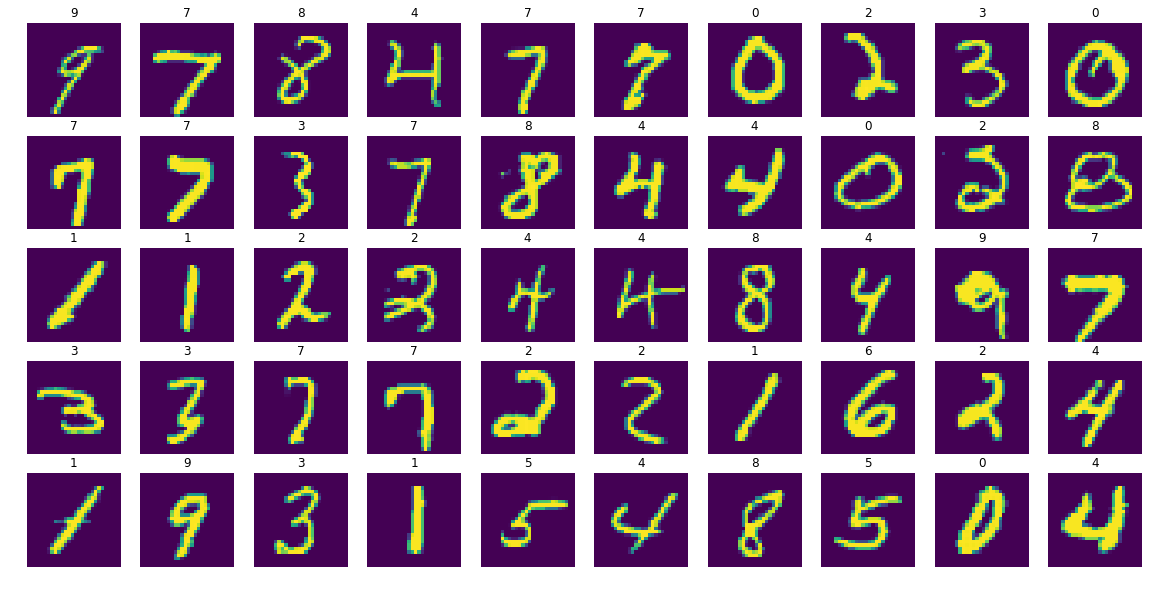

In [42]:
view_images_grid(x, y, label_dict)

In [43]:
x = x.reshape(x.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

In [44]:
train = torch.from_numpy(x).float()
train_labels = torch.from_numpy(y).long()
test = torch.from_numpy(x_test).float()
test_labels = torch.from_numpy(y_test).long()

In [45]:
train.shape

torch.Size([60000, 784])

In [46]:
train_labels.shape

torch.Size([60000])

### Describe model

In [47]:
def build_model(input_size = 784, output_size = 10, hidden_sizes = [256, 128, 64], dropout = 0.0):
    return nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                            ('bn2', nn.BatchNorm1d(num_features = hidden_sizes[1])),
                            ('relu2', nn.ReLU()),
                            ('dropout', nn.Dropout(dropout)),
                            ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                            ('bn3', nn.BatchNorm1d(num_features = hidden_sizes[2])),
                            ('relu3', nn.ReLU()),
                            ('logits', nn.Linear(hidden_sizes[2], output_size))]))

### Research

In [48]:
def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [49]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0):
    print("Fitting model with epochs = {epochs}, learning rate = {lr}"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [50]:
def get_preds(model, input):
    with torch.no_grad():
        logits = model.forward(input)

    ps = F.softmax(logits, dim=1)
    return ps

In [51]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [52]:
def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {}".format(accuracy_train))
    print("Accuracy score for test set is {}".format(accuracy_test))
    return accuracy_train, accuracy_test

Plot learning curve depending on the number of epochs.

In [53]:
learning_rate = 0.003
weight_decay = 0.0
n_chunks = 1000

In [18]:
epochs_range = np.arange(10, 150, 10)
train_acc = []
test_acc = []

for epochs in epochs_range:
    model = build_model()
    fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)
    accuracy_train, accuracy_test = evaluate_model(model, train, train_labels, test, test_labels)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

Fitting model with epochs = 10, learning rate = 0.003
Epoch: 1/10  Loss: 0.5798
Epoch: 1/10  Loss: 0.2645
Epoch: 1/10  Loss: 0.2424
Epoch: 1/10  Loss: 0.1908
Epoch: 1/10  Loss: 0.1870
Epoch: 1/10  Loss: 0.1671
Epoch: 1/10  Loss: 0.1553
Epoch: 1/10  Loss: 0.1468
Epoch: 1/10  Loss: 0.1482
Epoch: 1/10  Loss: 0.1338
Epoch: 2/10  Loss: 0.1101
Epoch: 2/10  Loss: 0.1030
Epoch: 2/10  Loss: 0.1078
Epoch: 2/10  Loss: 0.0922
Epoch: 2/10  Loss: 0.1046
Epoch: 2/10  Loss: 0.1114
Epoch: 2/10  Loss: 0.0936
Epoch: 2/10  Loss: 0.1025
Epoch: 2/10  Loss: 0.1039
Epoch: 2/10  Loss: 0.1093
Epoch: 3/10  Loss: 0.0763
Epoch: 3/10  Loss: 0.0779
Epoch: 3/10  Loss: 0.0729
Epoch: 3/10  Loss: 0.0659
Epoch: 3/10  Loss: 0.0760
Epoch: 3/10  Loss: 0.0739
Epoch: 3/10  Loss: 0.0761
Epoch: 3/10  Loss: 0.0857
Epoch: 3/10  Loss: 0.0846
Epoch: 3/10  Loss: 0.0684
Epoch: 4/10  Loss: 0.0515
Epoch: 4/10  Loss: 0.0650
Epoch: 4/10  Loss: 0.0676
Epoch: 4/10  Loss: 0.0616
Epoch: 4/10  Loss: 0.0625
Epoch: 4/10  Loss: 0.0714
Epoch: 4/1

Epoch: 1/30  Loss: 0.5946
Epoch: 1/30  Loss: 0.2740
Epoch: 1/30  Loss: 0.2167
Epoch: 1/30  Loss: 0.2024
Epoch: 1/30  Loss: 0.1730
Epoch: 1/30  Loss: 0.1735
Epoch: 1/30  Loss: 0.1478
Epoch: 1/30  Loss: 0.1347
Epoch: 1/30  Loss: 0.1356
Epoch: 1/30  Loss: 0.1250
Epoch: 2/30  Loss: 0.1035
Epoch: 2/30  Loss: 0.1067
Epoch: 2/30  Loss: 0.1088
Epoch: 2/30  Loss: 0.1105
Epoch: 2/30  Loss: 0.1169
Epoch: 2/30  Loss: 0.1076
Epoch: 2/30  Loss: 0.1056
Epoch: 2/30  Loss: 0.1114
Epoch: 2/30  Loss: 0.0987
Epoch: 2/30  Loss: 0.1002
Epoch: 3/30  Loss: 0.0715
Epoch: 3/30  Loss: 0.0665
Epoch: 3/30  Loss: 0.0821
Epoch: 3/30  Loss: 0.0835
Epoch: 3/30  Loss: 0.0750
Epoch: 3/30  Loss: 0.0811
Epoch: 3/30  Loss: 0.0819
Epoch: 3/30  Loss: 0.0807
Epoch: 3/30  Loss: 0.0739
Epoch: 3/30  Loss: 0.0762
Epoch: 4/30  Loss: 0.0537
Epoch: 4/30  Loss: 0.0511
Epoch: 4/30  Loss: 0.0611
Epoch: 4/30  Loss: 0.0709
Epoch: 4/30  Loss: 0.0576
Epoch: 4/30  Loss: 0.0659
Epoch: 4/30  Loss: 0.0692
Epoch: 4/30  Loss: 0.0659
Epoch: 4/30 

Epoch: 1/40  Loss: 0.2109
Epoch: 1/40  Loss: 0.2018
Epoch: 1/40  Loss: 0.1791
Epoch: 1/40  Loss: 0.1803
Epoch: 1/40  Loss: 0.1465
Epoch: 1/40  Loss: 0.1552
Epoch: 1/40  Loss: 0.1536
Epoch: 1/40  Loss: 0.1134
Epoch: 2/40  Loss: 0.1094
Epoch: 2/40  Loss: 0.1011
Epoch: 2/40  Loss: 0.1174
Epoch: 2/40  Loss: 0.1087
Epoch: 2/40  Loss: 0.1151
Epoch: 2/40  Loss: 0.1069
Epoch: 2/40  Loss: 0.0948
Epoch: 2/40  Loss: 0.1063
Epoch: 2/40  Loss: 0.0984
Epoch: 2/40  Loss: 0.0836
Epoch: 3/40  Loss: 0.0707
Epoch: 3/40  Loss: 0.0688
Epoch: 3/40  Loss: 0.0625
Epoch: 3/40  Loss: 0.0842
Epoch: 3/40  Loss: 0.0763
Epoch: 3/40  Loss: 0.0855
Epoch: 3/40  Loss: 0.0948
Epoch: 3/40  Loss: 0.0923
Epoch: 3/40  Loss: 0.0824
Epoch: 3/40  Loss: 0.0788
Epoch: 4/40  Loss: 0.0574
Epoch: 4/40  Loss: 0.0556
Epoch: 4/40  Loss: 0.0529
Epoch: 4/40  Loss: 0.0593
Epoch: 4/40  Loss: 0.0612
Epoch: 4/40  Loss: 0.0785
Epoch: 4/40  Loss: 0.0632
Epoch: 4/40  Loss: 0.0711
Epoch: 4/40  Loss: 0.0630
Epoch: 4/40  Loss: 0.0609
Epoch: 5/40 

Epoch: 31/40  Loss: 0.0083
Epoch: 32/40  Loss: 0.0090
Epoch: 32/40  Loss: 0.0051
Epoch: 32/40  Loss: 0.0038
Epoch: 32/40  Loss: 0.0045
Epoch: 32/40  Loss: 0.0107
Epoch: 32/40  Loss: 0.0130
Epoch: 32/40  Loss: 0.0071
Epoch: 32/40  Loss: 0.0113
Epoch: 32/40  Loss: 0.0091
Epoch: 32/40  Loss: 0.0094
Epoch: 33/40  Loss: 0.0065
Epoch: 33/40  Loss: 0.0041
Epoch: 33/40  Loss: 0.0105
Epoch: 33/40  Loss: 0.0162
Epoch: 33/40  Loss: 0.0063
Epoch: 33/40  Loss: 0.0075
Epoch: 33/40  Loss: 0.0075
Epoch: 33/40  Loss: 0.0055
Epoch: 33/40  Loss: 0.0023
Epoch: 33/40  Loss: 0.0083
Epoch: 34/40  Loss: 0.0064
Epoch: 34/40  Loss: 0.0085
Epoch: 34/40  Loss: 0.0078
Epoch: 34/40  Loss: 0.0062
Epoch: 34/40  Loss: 0.0088
Epoch: 34/40  Loss: 0.0060
Epoch: 34/40  Loss: 0.0112
Epoch: 34/40  Loss: 0.0120
Epoch: 34/40  Loss: 0.0072
Epoch: 34/40  Loss: 0.0043
Epoch: 35/40  Loss: 0.0064
Epoch: 35/40  Loss: 0.0058
Epoch: 35/40  Loss: 0.0064
Epoch: 35/40  Loss: 0.0088
Epoch: 35/40  Loss: 0.0110
Epoch: 35/40  Loss: 0.0093
E

Epoch: 22/50  Loss: 0.0142
Epoch: 22/50  Loss: 0.0105
Epoch: 22/50  Loss: 0.0113
Epoch: 22/50  Loss: 0.0091
Epoch: 22/50  Loss: 0.0103
Epoch: 22/50  Loss: 0.0167
Epoch: 22/50  Loss: 0.0199
Epoch: 22/50  Loss: 0.0125
Epoch: 22/50  Loss: 0.0107
Epoch: 23/50  Loss: 0.0083
Epoch: 23/50  Loss: 0.0113
Epoch: 23/50  Loss: 0.0089
Epoch: 23/50  Loss: 0.0120
Epoch: 23/50  Loss: 0.0112
Epoch: 23/50  Loss: 0.0166
Epoch: 23/50  Loss: 0.0110
Epoch: 23/50  Loss: 0.0094
Epoch: 23/50  Loss: 0.0085
Epoch: 23/50  Loss: 0.0148
Epoch: 24/50  Loss: 0.0073
Epoch: 24/50  Loss: 0.0105
Epoch: 24/50  Loss: 0.0116
Epoch: 24/50  Loss: 0.0106
Epoch: 24/50  Loss: 0.0109
Epoch: 24/50  Loss: 0.0071
Epoch: 24/50  Loss: 0.0129
Epoch: 24/50  Loss: 0.0213
Epoch: 24/50  Loss: 0.0139
Epoch: 24/50  Loss: 0.0154
Epoch: 25/50  Loss: 0.0053
Epoch: 25/50  Loss: 0.0115
Epoch: 25/50  Loss: 0.0097
Epoch: 25/50  Loss: 0.0085
Epoch: 25/50  Loss: 0.0083
Epoch: 25/50  Loss: 0.0111
Epoch: 25/50  Loss: 0.0066
Epoch: 25/50  Loss: 0.0098
E

Epoch: 2/60  Loss: 0.1123
Epoch: 2/60  Loss: 0.1110
Epoch: 2/60  Loss: 0.1088
Epoch: 2/60  Loss: 0.1081
Epoch: 2/60  Loss: 0.1180
Epoch: 2/60  Loss: 0.0963
Epoch: 2/60  Loss: 0.0940
Epoch: 2/60  Loss: 0.1015
Epoch: 2/60  Loss: 0.1002
Epoch: 2/60  Loss: 0.0930
Epoch: 3/60  Loss: 0.0898
Epoch: 3/60  Loss: 0.0777
Epoch: 3/60  Loss: 0.0683
Epoch: 3/60  Loss: 0.0889
Epoch: 3/60  Loss: 0.0775
Epoch: 3/60  Loss: 0.0915
Epoch: 3/60  Loss: 0.0755
Epoch: 3/60  Loss: 0.0679
Epoch: 3/60  Loss: 0.0841
Epoch: 3/60  Loss: 0.0819
Epoch: 4/60  Loss: 0.0540
Epoch: 4/60  Loss: 0.0646
Epoch: 4/60  Loss: 0.0642
Epoch: 4/60  Loss: 0.0653
Epoch: 4/60  Loss: 0.0710
Epoch: 4/60  Loss: 0.0627
Epoch: 4/60  Loss: 0.0718
Epoch: 4/60  Loss: 0.0781
Epoch: 4/60  Loss: 0.0672
Epoch: 4/60  Loss: 0.0527
Epoch: 5/60  Loss: 0.0451
Epoch: 5/60  Loss: 0.0473
Epoch: 5/60  Loss: 0.0551
Epoch: 5/60  Loss: 0.0470
Epoch: 5/60  Loss: 0.0538
Epoch: 5/60  Loss: 0.0608
Epoch: 5/60  Loss: 0.0484
Epoch: 5/60  Loss: 0.0632
Epoch: 5/60 

Epoch: 32/60  Loss: 0.0107
Epoch: 32/60  Loss: 0.0097
Epoch: 32/60  Loss: 0.0135
Epoch: 33/60  Loss: 0.0061
Epoch: 33/60  Loss: 0.0075
Epoch: 33/60  Loss: 0.0076
Epoch: 33/60  Loss: 0.0040
Epoch: 33/60  Loss: 0.0069
Epoch: 33/60  Loss: 0.0083
Epoch: 33/60  Loss: 0.0073
Epoch: 33/60  Loss: 0.0044
Epoch: 33/60  Loss: 0.0088
Epoch: 33/60  Loss: 0.0125
Epoch: 34/60  Loss: 0.0074
Epoch: 34/60  Loss: 0.0082
Epoch: 34/60  Loss: 0.0067
Epoch: 34/60  Loss: 0.0043
Epoch: 34/60  Loss: 0.0060
Epoch: 34/60  Loss: 0.0108
Epoch: 34/60  Loss: 0.0065
Epoch: 34/60  Loss: 0.0122
Epoch: 34/60  Loss: 0.0085
Epoch: 34/60  Loss: 0.0156
Epoch: 35/60  Loss: 0.0084
Epoch: 35/60  Loss: 0.0086
Epoch: 35/60  Loss: 0.0063
Epoch: 35/60  Loss: 0.0039
Epoch: 35/60  Loss: 0.0044
Epoch: 35/60  Loss: 0.0064
Epoch: 35/60  Loss: 0.0061
Epoch: 35/60  Loss: 0.0092
Epoch: 35/60  Loss: 0.0097
Epoch: 35/60  Loss: 0.0135
Epoch: 36/60  Loss: 0.0079
Epoch: 36/60  Loss: 0.0114
Epoch: 36/60  Loss: 0.0065
Epoch: 36/60  Loss: 0.0069
E

Epoch: 2/70  Loss: 0.1010
Epoch: 2/70  Loss: 0.0961
Epoch: 2/70  Loss: 0.1087
Epoch: 2/70  Loss: 0.0965
Epoch: 3/70  Loss: 0.0810
Epoch: 3/70  Loss: 0.0825
Epoch: 3/70  Loss: 0.0864
Epoch: 3/70  Loss: 0.0759
Epoch: 3/70  Loss: 0.0820
Epoch: 3/70  Loss: 0.0715
Epoch: 3/70  Loss: 0.0843
Epoch: 3/70  Loss: 0.0782
Epoch: 3/70  Loss: 0.0815
Epoch: 3/70  Loss: 0.0719
Epoch: 4/70  Loss: 0.0554
Epoch: 4/70  Loss: 0.0653
Epoch: 4/70  Loss: 0.0660
Epoch: 4/70  Loss: 0.0569
Epoch: 4/70  Loss: 0.0592
Epoch: 4/70  Loss: 0.0596
Epoch: 4/70  Loss: 0.0709
Epoch: 4/70  Loss: 0.0691
Epoch: 4/70  Loss: 0.0654
Epoch: 4/70  Loss: 0.0684
Epoch: 5/70  Loss: 0.0533
Epoch: 5/70  Loss: 0.0481
Epoch: 5/70  Loss: 0.0510
Epoch: 5/70  Loss: 0.0485
Epoch: 5/70  Loss: 0.0707
Epoch: 5/70  Loss: 0.0631
Epoch: 5/70  Loss: 0.0511
Epoch: 5/70  Loss: 0.0523
Epoch: 5/70  Loss: 0.0590
Epoch: 5/70  Loss: 0.0528
Epoch: 6/70  Loss: 0.0394
Epoch: 6/70  Loss: 0.0442
Epoch: 6/70  Loss: 0.0413
Epoch: 6/70  Loss: 0.0466
Epoch: 6/70 

Epoch: 33/70  Loss: 0.0033
Epoch: 33/70  Loss: 0.0048
Epoch: 33/70  Loss: 0.0027
Epoch: 33/70  Loss: 0.0077
Epoch: 33/70  Loss: 0.0067
Epoch: 33/70  Loss: 0.0119
Epoch: 33/70  Loss: 0.0070
Epoch: 34/70  Loss: 0.0082
Epoch: 34/70  Loss: 0.0169
Epoch: 34/70  Loss: 0.0079
Epoch: 34/70  Loss: 0.0090
Epoch: 34/70  Loss: 0.0097
Epoch: 34/70  Loss: 0.0128
Epoch: 34/70  Loss: 0.0064
Epoch: 34/70  Loss: 0.0066
Epoch: 34/70  Loss: 0.0110
Epoch: 34/70  Loss: 0.0076
Epoch: 35/70  Loss: 0.0088
Epoch: 35/70  Loss: 0.0070
Epoch: 35/70  Loss: 0.0079
Epoch: 35/70  Loss: 0.0112
Epoch: 35/70  Loss: 0.0039
Epoch: 35/70  Loss: 0.0077
Epoch: 35/70  Loss: 0.0071
Epoch: 35/70  Loss: 0.0115
Epoch: 35/70  Loss: 0.0096
Epoch: 35/70  Loss: 0.0076
Epoch: 36/70  Loss: 0.0061
Epoch: 36/70  Loss: 0.0035
Epoch: 36/70  Loss: 0.0034
Epoch: 36/70  Loss: 0.0056
Epoch: 36/70  Loss: 0.0086
Epoch: 36/70  Loss: 0.0113
Epoch: 36/70  Loss: 0.0145
Epoch: 36/70  Loss: 0.0073
Epoch: 36/70  Loss: 0.0090
Epoch: 36/70  Loss: 0.0097
E

Epoch: 63/70  Loss: 0.0055
Epoch: 63/70  Loss: 0.0056
Epoch: 63/70  Loss: 0.0065
Epoch: 64/70  Loss: 0.0023
Epoch: 64/70  Loss: 0.0026
Epoch: 64/70  Loss: 0.0029
Epoch: 64/70  Loss: 0.0070
Epoch: 64/70  Loss: 0.0042
Epoch: 64/70  Loss: 0.0075
Epoch: 64/70  Loss: 0.0052
Epoch: 64/70  Loss: 0.0029
Epoch: 64/70  Loss: 0.0025
Epoch: 64/70  Loss: 0.0015
Epoch: 65/70  Loss: 0.0023
Epoch: 65/70  Loss: 0.0007
Epoch: 65/70  Loss: 0.0026
Epoch: 65/70  Loss: 0.0022
Epoch: 65/70  Loss: 0.0038
Epoch: 65/70  Loss: 0.0022
Epoch: 65/70  Loss: 0.0039
Epoch: 65/70  Loss: 0.0033
Epoch: 65/70  Loss: 0.0067
Epoch: 65/70  Loss: 0.0038
Epoch: 66/70  Loss: 0.0047
Epoch: 66/70  Loss: 0.0050
Epoch: 66/70  Loss: 0.0051
Epoch: 66/70  Loss: 0.0063
Epoch: 66/70  Loss: 0.0034
Epoch: 66/70  Loss: 0.0047
Epoch: 66/70  Loss: 0.0049
Epoch: 66/70  Loss: 0.0033
Epoch: 66/70  Loss: 0.0065
Epoch: 66/70  Loss: 0.0039
Epoch: 67/70  Loss: 0.0034
Epoch: 67/70  Loss: 0.0033
Epoch: 67/70  Loss: 0.0023
Epoch: 67/70  Loss: 0.0044
E

Epoch: 23/80  Loss: 0.0077
Epoch: 24/80  Loss: 0.0053
Epoch: 24/80  Loss: 0.0093
Epoch: 24/80  Loss: 0.0078
Epoch: 24/80  Loss: 0.0131
Epoch: 24/80  Loss: 0.0153
Epoch: 24/80  Loss: 0.0141
Epoch: 24/80  Loss: 0.0119
Epoch: 24/80  Loss: 0.0082
Epoch: 24/80  Loss: 0.0137
Epoch: 24/80  Loss: 0.0103
Epoch: 25/80  Loss: 0.0132
Epoch: 25/80  Loss: 0.0137
Epoch: 25/80  Loss: 0.0133
Epoch: 25/80  Loss: 0.0111
Epoch: 25/80  Loss: 0.0122
Epoch: 25/80  Loss: 0.0092
Epoch: 25/80  Loss: 0.0102
Epoch: 25/80  Loss: 0.0141
Epoch: 25/80  Loss: 0.0168
Epoch: 25/80  Loss: 0.0142
Epoch: 26/80  Loss: 0.0114
Epoch: 26/80  Loss: 0.0064
Epoch: 26/80  Loss: 0.0053
Epoch: 26/80  Loss: 0.0087
Epoch: 26/80  Loss: 0.0078
Epoch: 26/80  Loss: 0.0088
Epoch: 26/80  Loss: 0.0104
Epoch: 26/80  Loss: 0.0076
Epoch: 26/80  Loss: 0.0091
Epoch: 26/80  Loss: 0.0149
Epoch: 27/80  Loss: 0.0113
Epoch: 27/80  Loss: 0.0048
Epoch: 27/80  Loss: 0.0083
Epoch: 27/80  Loss: 0.0097
Epoch: 27/80  Loss: 0.0094
Epoch: 27/80  Loss: 0.0058
E

Epoch: 54/80  Loss: 0.0055
Epoch: 54/80  Loss: 0.0060
Epoch: 54/80  Loss: 0.0044
Epoch: 54/80  Loss: 0.0045
Epoch: 54/80  Loss: 0.0047
Epoch: 54/80  Loss: 0.0028
Epoch: 54/80  Loss: 0.0076
Epoch: 55/80  Loss: 0.0140
Epoch: 55/80  Loss: 0.0063
Epoch: 55/80  Loss: 0.0067
Epoch: 55/80  Loss: 0.0039
Epoch: 55/80  Loss: 0.0018
Epoch: 55/80  Loss: 0.0024
Epoch: 55/80  Loss: 0.0017
Epoch: 55/80  Loss: 0.0029
Epoch: 55/80  Loss: 0.0034
Epoch: 55/80  Loss: 0.0093
Epoch: 56/80  Loss: 0.0048
Epoch: 56/80  Loss: 0.0045
Epoch: 56/80  Loss: 0.0078
Epoch: 56/80  Loss: 0.0047
Epoch: 56/80  Loss: 0.0019
Epoch: 56/80  Loss: 0.0010
Epoch: 56/80  Loss: 0.0035
Epoch: 56/80  Loss: 0.0036
Epoch: 56/80  Loss: 0.0021
Epoch: 56/80  Loss: 0.0057
Epoch: 57/80  Loss: 0.0025
Epoch: 57/80  Loss: 0.0049
Epoch: 57/80  Loss: 0.0072
Epoch: 57/80  Loss: 0.0064
Epoch: 57/80  Loss: 0.0055
Epoch: 57/80  Loss: 0.0033
Epoch: 57/80  Loss: 0.0030
Epoch: 57/80  Loss: 0.0029
Epoch: 57/80  Loss: 0.0028
Epoch: 57/80  Loss: 0.0023
E

Epoch: 4/90  Loss: 0.0683
Epoch: 4/90  Loss: 0.0751
Epoch: 4/90  Loss: 0.0702
Epoch: 4/90  Loss: 0.0711
Epoch: 4/90  Loss: 0.0692
Epoch: 4/90  Loss: 0.0702
Epoch: 4/90  Loss: 0.0723
Epoch: 5/90  Loss: 0.0475
Epoch: 5/90  Loss: 0.0460
Epoch: 5/90  Loss: 0.0434
Epoch: 5/90  Loss: 0.0490
Epoch: 5/90  Loss: 0.0599
Epoch: 5/90  Loss: 0.0506
Epoch: 5/90  Loss: 0.0485
Epoch: 5/90  Loss: 0.0554
Epoch: 5/90  Loss: 0.0532
Epoch: 5/90  Loss: 0.0653
Epoch: 6/90  Loss: 0.0427
Epoch: 6/90  Loss: 0.0395
Epoch: 6/90  Loss: 0.0555
Epoch: 6/90  Loss: 0.0503
Epoch: 6/90  Loss: 0.0535
Epoch: 6/90  Loss: 0.0421
Epoch: 6/90  Loss: 0.0530
Epoch: 6/90  Loss: 0.0559
Epoch: 6/90  Loss: 0.0520
Epoch: 6/90  Loss: 0.0504
Epoch: 7/90  Loss: 0.0374
Epoch: 7/90  Loss: 0.0340
Epoch: 7/90  Loss: 0.0479
Epoch: 7/90  Loss: 0.0370
Epoch: 7/90  Loss: 0.0451
Epoch: 7/90  Loss: 0.0326
Epoch: 7/90  Loss: 0.0403
Epoch: 7/90  Loss: 0.0452
Epoch: 7/90  Loss: 0.0498
Epoch: 7/90  Loss: 0.0430
Epoch: 8/90  Loss: 0.0315
Epoch: 8/90 

Epoch: 34/90  Loss: 0.0079
Epoch: 35/90  Loss: 0.0050
Epoch: 35/90  Loss: 0.0071
Epoch: 35/90  Loss: 0.0032
Epoch: 35/90  Loss: 0.0052
Epoch: 35/90  Loss: 0.0069
Epoch: 35/90  Loss: 0.0093
Epoch: 35/90  Loss: 0.0054
Epoch: 35/90  Loss: 0.0097
Epoch: 35/90  Loss: 0.0059
Epoch: 35/90  Loss: 0.0124
Epoch: 36/90  Loss: 0.0074
Epoch: 36/90  Loss: 0.0058
Epoch: 36/90  Loss: 0.0150
Epoch: 36/90  Loss: 0.0069
Epoch: 36/90  Loss: 0.0063
Epoch: 36/90  Loss: 0.0082
Epoch: 36/90  Loss: 0.0089
Epoch: 36/90  Loss: 0.0078
Epoch: 36/90  Loss: 0.0109
Epoch: 36/90  Loss: 0.0073
Epoch: 37/90  Loss: 0.0078
Epoch: 37/90  Loss: 0.0028
Epoch: 37/90  Loss: 0.0091
Epoch: 37/90  Loss: 0.0075
Epoch: 37/90  Loss: 0.0054
Epoch: 37/90  Loss: 0.0077
Epoch: 37/90  Loss: 0.0095
Epoch: 37/90  Loss: 0.0088
Epoch: 37/90  Loss: 0.0052
Epoch: 37/90  Loss: 0.0112
Epoch: 38/90  Loss: 0.0121
Epoch: 38/90  Loss: 0.0050
Epoch: 38/90  Loss: 0.0060
Epoch: 38/90  Loss: 0.0048
Epoch: 38/90  Loss: 0.0068
Epoch: 38/90  Loss: 0.0067
E

Epoch: 65/90  Loss: 0.0049
Epoch: 65/90  Loss: 0.0078
Epoch: 65/90  Loss: 0.0047
Epoch: 65/90  Loss: 0.0053
Epoch: 65/90  Loss: 0.0032
Epoch: 65/90  Loss: 0.0046
Epoch: 65/90  Loss: 0.0053
Epoch: 66/90  Loss: 0.0022
Epoch: 66/90  Loss: 0.0032
Epoch: 66/90  Loss: 0.0023
Epoch: 66/90  Loss: 0.0017
Epoch: 66/90  Loss: 0.0023
Epoch: 66/90  Loss: 0.0066
Epoch: 66/90  Loss: 0.0056
Epoch: 66/90  Loss: 0.0030
Epoch: 66/90  Loss: 0.0013
Epoch: 66/90  Loss: 0.0017
Epoch: 67/90  Loss: 0.0020
Epoch: 67/90  Loss: 0.0075
Epoch: 67/90  Loss: 0.0031
Epoch: 67/90  Loss: 0.0039
Epoch: 67/90  Loss: 0.0029
Epoch: 67/90  Loss: 0.0033
Epoch: 67/90  Loss: 0.0036
Epoch: 67/90  Loss: 0.0039
Epoch: 67/90  Loss: 0.0064
Epoch: 67/90  Loss: 0.0049
Epoch: 68/90  Loss: 0.0056
Epoch: 68/90  Loss: 0.0070
Epoch: 68/90  Loss: 0.0041
Epoch: 68/90  Loss: 0.0032
Epoch: 68/90  Loss: 0.0043
Epoch: 68/90  Loss: 0.0035
Epoch: 68/90  Loss: 0.0062
Epoch: 68/90  Loss: 0.0020
Epoch: 68/90  Loss: 0.0035
Epoch: 68/90  Loss: 0.0022
E

Epoch: 5/100  Loss: 0.0500
Epoch: 5/100  Loss: 0.0568
Epoch: 5/100  Loss: 0.0514
Epoch: 5/100  Loss: 0.0664
Epoch: 5/100  Loss: 0.0541
Epoch: 5/100  Loss: 0.0588
Epoch: 5/100  Loss: 0.0541
Epoch: 5/100  Loss: 0.0652
Epoch: 6/100  Loss: 0.0370
Epoch: 6/100  Loss: 0.0379
Epoch: 6/100  Loss: 0.0367
Epoch: 6/100  Loss: 0.0496
Epoch: 6/100  Loss: 0.0465
Epoch: 6/100  Loss: 0.0565
Epoch: 6/100  Loss: 0.0580
Epoch: 6/100  Loss: 0.0472
Epoch: 6/100  Loss: 0.0599
Epoch: 6/100  Loss: 0.0546
Epoch: 7/100  Loss: 0.0296
Epoch: 7/100  Loss: 0.0306
Epoch: 7/100  Loss: 0.0231
Epoch: 7/100  Loss: 0.0428
Epoch: 7/100  Loss: 0.0427
Epoch: 7/100  Loss: 0.0507
Epoch: 7/100  Loss: 0.0404
Epoch: 7/100  Loss: 0.0441
Epoch: 7/100  Loss: 0.0510
Epoch: 7/100  Loss: 0.0532
Epoch: 8/100  Loss: 0.0313
Epoch: 8/100  Loss: 0.0380
Epoch: 8/100  Loss: 0.0373
Epoch: 8/100  Loss: 0.0421
Epoch: 8/100  Loss: 0.0308
Epoch: 8/100  Loss: 0.0400
Epoch: 8/100  Loss: 0.0308
Epoch: 8/100  Loss: 0.0394
Epoch: 8/100  Loss: 0.0363
E

Epoch: 34/100  Loss: 0.0082
Epoch: 34/100  Loss: 0.0203
Epoch: 34/100  Loss: 0.0152
Epoch: 35/100  Loss: 0.0055
Epoch: 35/100  Loss: 0.0097
Epoch: 35/100  Loss: 0.0046
Epoch: 35/100  Loss: 0.0093
Epoch: 35/100  Loss: 0.0100
Epoch: 35/100  Loss: 0.0079
Epoch: 35/100  Loss: 0.0056
Epoch: 35/100  Loss: 0.0063
Epoch: 35/100  Loss: 0.0047
Epoch: 35/100  Loss: 0.0080
Epoch: 36/100  Loss: 0.0076
Epoch: 36/100  Loss: 0.0038
Epoch: 36/100  Loss: 0.0059
Epoch: 36/100  Loss: 0.0035
Epoch: 36/100  Loss: 0.0054
Epoch: 36/100  Loss: 0.0080
Epoch: 36/100  Loss: 0.0083
Epoch: 36/100  Loss: 0.0094
Epoch: 36/100  Loss: 0.0073
Epoch: 36/100  Loss: 0.0102
Epoch: 37/100  Loss: 0.0050
Epoch: 37/100  Loss: 0.0074
Epoch: 37/100  Loss: 0.0100
Epoch: 37/100  Loss: 0.0091
Epoch: 37/100  Loss: 0.0069
Epoch: 37/100  Loss: 0.0118
Epoch: 37/100  Loss: 0.0125
Epoch: 37/100  Loss: 0.0061
Epoch: 37/100  Loss: 0.0082
Epoch: 37/100  Loss: 0.0076
Epoch: 38/100  Loss: 0.0063
Epoch: 38/100  Loss: 0.0073
Epoch: 38/100  Loss:

Epoch: 64/100  Loss: 0.0092
Epoch: 64/100  Loss: 0.0022
Epoch: 64/100  Loss: 0.0041
Epoch: 64/100  Loss: 0.0047
Epoch: 64/100  Loss: 0.0027
Epoch: 64/100  Loss: 0.0034
Epoch: 64/100  Loss: 0.0071
Epoch: 64/100  Loss: 0.0024
Epoch: 64/100  Loss: 0.0023
Epoch: 64/100  Loss: 0.0029
Epoch: 65/100  Loss: 0.0060
Epoch: 65/100  Loss: 0.0051
Epoch: 65/100  Loss: 0.0025
Epoch: 65/100  Loss: 0.0025
Epoch: 65/100  Loss: 0.0018
Epoch: 65/100  Loss: 0.0022
Epoch: 65/100  Loss: 0.0052
Epoch: 65/100  Loss: 0.0042
Epoch: 65/100  Loss: 0.0020
Epoch: 65/100  Loss: 0.0026
Epoch: 66/100  Loss: 0.0045
Epoch: 66/100  Loss: 0.0068
Epoch: 66/100  Loss: 0.0026
Epoch: 66/100  Loss: 0.0055
Epoch: 66/100  Loss: 0.0050
Epoch: 66/100  Loss: 0.0019
Epoch: 66/100  Loss: 0.0061
Epoch: 66/100  Loss: 0.0088
Epoch: 66/100  Loss: 0.0008
Epoch: 66/100  Loss: 0.0023
Epoch: 67/100  Loss: 0.0053
Epoch: 67/100  Loss: 0.0048
Epoch: 67/100  Loss: 0.0049
Epoch: 67/100  Loss: 0.0071
Epoch: 67/100  Loss: 0.0030
Epoch: 67/100  Loss:

Epoch: 93/100  Loss: 0.0023
Epoch: 93/100  Loss: 0.0019
Epoch: 93/100  Loss: 0.0034
Epoch: 93/100  Loss: 0.0039
Epoch: 93/100  Loss: 0.0019
Epoch: 93/100  Loss: 0.0046
Epoch: 93/100  Loss: 0.0056
Epoch: 94/100  Loss: 0.0033
Epoch: 94/100  Loss: 0.0034
Epoch: 94/100  Loss: 0.0020
Epoch: 94/100  Loss: 0.0010
Epoch: 94/100  Loss: 0.0032
Epoch: 94/100  Loss: 0.0041
Epoch: 94/100  Loss: 0.0030
Epoch: 94/100  Loss: 0.0011
Epoch: 94/100  Loss: 0.0026
Epoch: 94/100  Loss: 0.0050
Epoch: 95/100  Loss: 0.0028
Epoch: 95/100  Loss: 0.0045
Epoch: 95/100  Loss: 0.0015
Epoch: 95/100  Loss: 0.0017
Epoch: 95/100  Loss: 0.0032
Epoch: 95/100  Loss: 0.0038
Epoch: 95/100  Loss: 0.0032
Epoch: 95/100  Loss: 0.0028
Epoch: 95/100  Loss: 0.0029
Epoch: 95/100  Loss: 0.0025
Epoch: 96/100  Loss: 0.0008
Epoch: 96/100  Loss: 0.0021
Epoch: 96/100  Loss: 0.0016
Epoch: 96/100  Loss: 0.0011
Epoch: 96/100  Loss: 0.0040
Epoch: 96/100  Loss: 0.0031
Epoch: 96/100  Loss: 0.0037
Epoch: 96/100  Loss: 0.0041
Epoch: 96/100  Loss:

Epoch: 22/110  Loss: 0.0121
Epoch: 22/110  Loss: 0.0139
Epoch: 22/110  Loss: 0.0184
Epoch: 22/110  Loss: 0.0125
Epoch: 22/110  Loss: 0.0174
Epoch: 22/110  Loss: 0.0143
Epoch: 23/110  Loss: 0.0148
Epoch: 23/110  Loss: 0.0113
Epoch: 23/110  Loss: 0.0113
Epoch: 23/110  Loss: 0.0127
Epoch: 23/110  Loss: 0.0179
Epoch: 23/110  Loss: 0.0092
Epoch: 23/110  Loss: 0.0132
Epoch: 23/110  Loss: 0.0153
Epoch: 23/110  Loss: 0.0098
Epoch: 23/110  Loss: 0.0111
Epoch: 24/110  Loss: 0.0104
Epoch: 24/110  Loss: 0.0105
Epoch: 24/110  Loss: 0.0079
Epoch: 24/110  Loss: 0.0115
Epoch: 24/110  Loss: 0.0102
Epoch: 24/110  Loss: 0.0079
Epoch: 24/110  Loss: 0.0095
Epoch: 24/110  Loss: 0.0073
Epoch: 24/110  Loss: 0.0104
Epoch: 24/110  Loss: 0.0144
Epoch: 25/110  Loss: 0.0062
Epoch: 25/110  Loss: 0.0121
Epoch: 25/110  Loss: 0.0079
Epoch: 25/110  Loss: 0.0091
Epoch: 25/110  Loss: 0.0110
Epoch: 25/110  Loss: 0.0098
Epoch: 25/110  Loss: 0.0149
Epoch: 25/110  Loss: 0.0063
Epoch: 25/110  Loss: 0.0160
Epoch: 25/110  Loss:

Epoch: 51/110  Loss: 0.0067
Epoch: 51/110  Loss: 0.0079
Epoch: 51/110  Loss: 0.0049
Epoch: 52/110  Loss: 0.0040
Epoch: 52/110  Loss: 0.0034
Epoch: 52/110  Loss: 0.0039
Epoch: 52/110  Loss: 0.0037
Epoch: 52/110  Loss: 0.0106
Epoch: 52/110  Loss: 0.0076
Epoch: 52/110  Loss: 0.0082
Epoch: 52/110  Loss: 0.0027
Epoch: 52/110  Loss: 0.0043
Epoch: 52/110  Loss: 0.0032
Epoch: 53/110  Loss: 0.0026
Epoch: 53/110  Loss: 0.0018
Epoch: 53/110  Loss: 0.0047
Epoch: 53/110  Loss: 0.0052
Epoch: 53/110  Loss: 0.0043
Epoch: 53/110  Loss: 0.0043
Epoch: 53/110  Loss: 0.0046
Epoch: 53/110  Loss: 0.0079
Epoch: 53/110  Loss: 0.0084
Epoch: 53/110  Loss: 0.0071
Epoch: 54/110  Loss: 0.0107
Epoch: 54/110  Loss: 0.0103
Epoch: 54/110  Loss: 0.0047
Epoch: 54/110  Loss: 0.0051
Epoch: 54/110  Loss: 0.0049
Epoch: 54/110  Loss: 0.0035
Epoch: 54/110  Loss: 0.0020
Epoch: 54/110  Loss: 0.0035
Epoch: 54/110  Loss: 0.0059
Epoch: 54/110  Loss: 0.0063
Epoch: 55/110  Loss: 0.0069
Epoch: 55/110  Loss: 0.0033
Epoch: 55/110  Loss:

Epoch: 81/110  Loss: 0.0012
Epoch: 81/110  Loss: 0.0005
Epoch: 81/110  Loss: 0.0016
Epoch: 81/110  Loss: 0.0011
Epoch: 81/110  Loss: 0.0031
Epoch: 81/110  Loss: 0.0069
Epoch: 81/110  Loss: 0.0060
Epoch: 81/110  Loss: 0.0070
Epoch: 81/110  Loss: 0.0051
Epoch: 81/110  Loss: 0.0022
Epoch: 82/110  Loss: 0.0029
Epoch: 82/110  Loss: 0.0042
Epoch: 82/110  Loss: 0.0036
Epoch: 82/110  Loss: 0.0054
Epoch: 82/110  Loss: 0.0043
Epoch: 82/110  Loss: 0.0022
Epoch: 82/110  Loss: 0.0057
Epoch: 82/110  Loss: 0.0072
Epoch: 82/110  Loss: 0.0056
Epoch: 82/110  Loss: 0.0027
Epoch: 83/110  Loss: 0.0025
Epoch: 83/110  Loss: 0.0020
Epoch: 83/110  Loss: 0.0041
Epoch: 83/110  Loss: 0.0021
Epoch: 83/110  Loss: 0.0044
Epoch: 83/110  Loss: 0.0044
Epoch: 83/110  Loss: 0.0026
Epoch: 83/110  Loss: 0.0049
Epoch: 83/110  Loss: 0.0031
Epoch: 83/110  Loss: 0.0095
Epoch: 84/110  Loss: 0.0032
Epoch: 84/110  Loss: 0.0021
Epoch: 84/110  Loss: 0.0009
Epoch: 84/110  Loss: 0.0028
Epoch: 84/110  Loss: 0.0015
Epoch: 84/110  Loss:

Epoch: 110/110  Loss: 0.0016
Epoch: 110/110  Loss: 0.0005
Epoch: 110/110  Loss: 0.0037
Epoch: 110/110  Loss: 0.0041
Epoch: 110/110  Loss: 0.0022
Epoch: 110/110  Loss: 0.0019
Epoch: 110/110  Loss: 0.0045
Epoch: 110/110  Loss: 0.0037
Epoch: 110/110  Loss: 0.0028
Epoch: 110/110  Loss: 0.0046
Accuracy score for train set is 0.9996833333333334
Accuracy score for test set is 0.9836
Fitting model with epochs = 120, learning rate = 0.003
Epoch: 1/120  Loss: 0.5647
Epoch: 1/120  Loss: 0.2480
Epoch: 1/120  Loss: 0.2269
Epoch: 1/120  Loss: 0.2169
Epoch: 1/120  Loss: 0.1712
Epoch: 1/120  Loss: 0.1610
Epoch: 1/120  Loss: 0.1601
Epoch: 1/120  Loss: 0.1395
Epoch: 1/120  Loss: 0.1538
Epoch: 1/120  Loss: 0.1367
Epoch: 2/120  Loss: 0.0994
Epoch: 2/120  Loss: 0.1015
Epoch: 2/120  Loss: 0.1076
Epoch: 2/120  Loss: 0.0995
Epoch: 2/120  Loss: 0.0976
Epoch: 2/120  Loss: 0.1118
Epoch: 2/120  Loss: 0.1041
Epoch: 2/120  Loss: 0.0978
Epoch: 2/120  Loss: 0.0923
Epoch: 2/120  Loss: 0.1155
Epoch: 3/120  Loss: 0.0721

Epoch: 29/120  Loss: 0.0083
Epoch: 29/120  Loss: 0.0096
Epoch: 29/120  Loss: 0.0146
Epoch: 29/120  Loss: 0.0095
Epoch: 29/120  Loss: 0.0070
Epoch: 29/120  Loss: 0.0117
Epoch: 29/120  Loss: 0.0114
Epoch: 29/120  Loss: 0.0148
Epoch: 29/120  Loss: 0.0149
Epoch: 30/120  Loss: 0.0071
Epoch: 30/120  Loss: 0.0076
Epoch: 30/120  Loss: 0.0054
Epoch: 30/120  Loss: 0.0076
Epoch: 30/120  Loss: 0.0063
Epoch: 30/120  Loss: 0.0068
Epoch: 30/120  Loss: 0.0059
Epoch: 30/120  Loss: 0.0118
Epoch: 30/120  Loss: 0.0116
Epoch: 30/120  Loss: 0.0083
Epoch: 31/120  Loss: 0.0068
Epoch: 31/120  Loss: 0.0091
Epoch: 31/120  Loss: 0.0137
Epoch: 31/120  Loss: 0.0095
Epoch: 31/120  Loss: 0.0065
Epoch: 31/120  Loss: 0.0078
Epoch: 31/120  Loss: 0.0091
Epoch: 31/120  Loss: 0.0083
Epoch: 31/120  Loss: 0.0107
Epoch: 31/120  Loss: 0.0146
Epoch: 32/120  Loss: 0.0088
Epoch: 32/120  Loss: 0.0069
Epoch: 32/120  Loss: 0.0107
Epoch: 32/120  Loss: 0.0067
Epoch: 32/120  Loss: 0.0087
Epoch: 32/120  Loss: 0.0097
Epoch: 32/120  Loss:

Epoch: 58/120  Loss: 0.0077
Epoch: 58/120  Loss: 0.0044
Epoch: 58/120  Loss: 0.0065
Epoch: 58/120  Loss: 0.0081
Epoch: 58/120  Loss: 0.0068
Epoch: 58/120  Loss: 0.0078
Epoch: 59/120  Loss: 0.0023
Epoch: 59/120  Loss: 0.0028
Epoch: 59/120  Loss: 0.0038
Epoch: 59/120  Loss: 0.0034
Epoch: 59/120  Loss: 0.0054
Epoch: 59/120  Loss: 0.0034
Epoch: 59/120  Loss: 0.0022
Epoch: 59/120  Loss: 0.0025
Epoch: 59/120  Loss: 0.0032
Epoch: 59/120  Loss: 0.0017
Epoch: 60/120  Loss: 0.0035
Epoch: 60/120  Loss: 0.0052
Epoch: 60/120  Loss: 0.0098
Epoch: 60/120  Loss: 0.0087
Epoch: 60/120  Loss: 0.0061
Epoch: 60/120  Loss: 0.0058
Epoch: 60/120  Loss: 0.0076
Epoch: 60/120  Loss: 0.0049
Epoch: 60/120  Loss: 0.0033
Epoch: 60/120  Loss: 0.0031
Epoch: 61/120  Loss: 0.0056
Epoch: 61/120  Loss: 0.0020
Epoch: 61/120  Loss: 0.0064
Epoch: 61/120  Loss: 0.0035
Epoch: 61/120  Loss: 0.0034
Epoch: 61/120  Loss: 0.0039
Epoch: 61/120  Loss: 0.0078
Epoch: 61/120  Loss: 0.0051
Epoch: 61/120  Loss: 0.0020
Epoch: 61/120  Loss:

Epoch: 87/120  Loss: 0.0038
Epoch: 87/120  Loss: 0.0022
Epoch: 87/120  Loss: 0.0032
Epoch: 88/120  Loss: 0.0020
Epoch: 88/120  Loss: 0.0014
Epoch: 88/120  Loss: 0.0046
Epoch: 88/120  Loss: 0.0011
Epoch: 88/120  Loss: 0.0029
Epoch: 88/120  Loss: 0.0022
Epoch: 88/120  Loss: 0.0027
Epoch: 88/120  Loss: 0.0008
Epoch: 88/120  Loss: 0.0010
Epoch: 88/120  Loss: 0.0005
Epoch: 89/120  Loss: 0.0013
Epoch: 89/120  Loss: 0.0028
Epoch: 89/120  Loss: 0.0023
Epoch: 89/120  Loss: 0.0031
Epoch: 89/120  Loss: 0.0025
Epoch: 89/120  Loss: 0.0030
Epoch: 89/120  Loss: 0.0023
Epoch: 89/120  Loss: 0.0006
Epoch: 89/120  Loss: 0.0036
Epoch: 89/120  Loss: 0.0042
Epoch: 90/120  Loss: 0.0094
Epoch: 90/120  Loss: 0.0051
Epoch: 90/120  Loss: 0.0027
Epoch: 90/120  Loss: 0.0049
Epoch: 90/120  Loss: 0.0044
Epoch: 90/120  Loss: 0.0011
Epoch: 90/120  Loss: 0.0021
Epoch: 90/120  Loss: 0.0039
Epoch: 90/120  Loss: 0.0040
Epoch: 90/120  Loss: 0.0037
Epoch: 91/120  Loss: 0.0028
Epoch: 91/120  Loss: 0.0089
Epoch: 91/120  Loss:

Epoch: 116/120  Loss: 0.0029
Epoch: 116/120  Loss: 0.0011
Epoch: 116/120  Loss: 0.0011
Epoch: 116/120  Loss: 0.0016
Epoch: 116/120  Loss: 0.0046
Epoch: 116/120  Loss: 0.0023
Epoch: 117/120  Loss: 0.0024
Epoch: 117/120  Loss: 0.0028
Epoch: 117/120  Loss: 0.0026
Epoch: 117/120  Loss: 0.0023
Epoch: 117/120  Loss: 0.0011
Epoch: 117/120  Loss: 0.0025
Epoch: 117/120  Loss: 0.0039
Epoch: 117/120  Loss: 0.0031
Epoch: 117/120  Loss: 0.0022
Epoch: 117/120  Loss: 0.0018
Epoch: 118/120  Loss: 0.0015
Epoch: 118/120  Loss: 0.0014
Epoch: 118/120  Loss: 0.0035
Epoch: 118/120  Loss: 0.0011
Epoch: 118/120  Loss: 0.0040
Epoch: 118/120  Loss: 0.0008
Epoch: 118/120  Loss: 0.0006
Epoch: 118/120  Loss: 0.0034
Epoch: 118/120  Loss: 0.0027
Epoch: 118/120  Loss: 0.0030
Epoch: 119/120  Loss: 0.0021
Epoch: 119/120  Loss: 0.0034
Epoch: 119/120  Loss: 0.0050
Epoch: 119/120  Loss: 0.0028
Epoch: 119/120  Loss: 0.0077
Epoch: 119/120  Loss: 0.0025
Epoch: 119/120  Loss: 0.0030
Epoch: 119/120  Loss: 0.0021
Epoch: 119/120

Epoch: 25/130  Loss: 0.0113
Epoch: 25/130  Loss: 0.0082
Epoch: 25/130  Loss: 0.0105
Epoch: 25/130  Loss: 0.0115
Epoch: 25/130  Loss: 0.0130
Epoch: 25/130  Loss: 0.0087
Epoch: 26/130  Loss: 0.0041
Epoch: 26/130  Loss: 0.0063
Epoch: 26/130  Loss: 0.0081
Epoch: 26/130  Loss: 0.0083
Epoch: 26/130  Loss: 0.0089
Epoch: 26/130  Loss: 0.0079
Epoch: 26/130  Loss: 0.0117
Epoch: 26/130  Loss: 0.0150
Epoch: 26/130  Loss: 0.0085
Epoch: 26/130  Loss: 0.0096
Epoch: 27/130  Loss: 0.0085
Epoch: 27/130  Loss: 0.0144
Epoch: 27/130  Loss: 0.0090
Epoch: 27/130  Loss: 0.0109
Epoch: 27/130  Loss: 0.0077
Epoch: 27/130  Loss: 0.0087
Epoch: 27/130  Loss: 0.0057
Epoch: 27/130  Loss: 0.0095
Epoch: 27/130  Loss: 0.0101
Epoch: 27/130  Loss: 0.0130
Epoch: 28/130  Loss: 0.0090
Epoch: 28/130  Loss: 0.0113
Epoch: 28/130  Loss: 0.0138
Epoch: 28/130  Loss: 0.0153
Epoch: 28/130  Loss: 0.0138
Epoch: 28/130  Loss: 0.0090
Epoch: 28/130  Loss: 0.0089
Epoch: 28/130  Loss: 0.0122
Epoch: 28/130  Loss: 0.0131
Epoch: 28/130  Loss:

Epoch: 54/130  Loss: 0.0068
Epoch: 54/130  Loss: 0.0085
Epoch: 54/130  Loss: 0.0137
Epoch: 55/130  Loss: 0.0069
Epoch: 55/130  Loss: 0.0043
Epoch: 55/130  Loss: 0.0050
Epoch: 55/130  Loss: 0.0033
Epoch: 55/130  Loss: 0.0053
Epoch: 55/130  Loss: 0.0045
Epoch: 55/130  Loss: 0.0030
Epoch: 55/130  Loss: 0.0027
Epoch: 55/130  Loss: 0.0029
Epoch: 55/130  Loss: 0.0024
Epoch: 56/130  Loss: 0.0021
Epoch: 56/130  Loss: 0.0032
Epoch: 56/130  Loss: 0.0040
Epoch: 56/130  Loss: 0.0026
Epoch: 56/130  Loss: 0.0048
Epoch: 56/130  Loss: 0.0041
Epoch: 56/130  Loss: 0.0092
Epoch: 56/130  Loss: 0.0023
Epoch: 56/130  Loss: 0.0017
Epoch: 56/130  Loss: 0.0055
Epoch: 57/130  Loss: 0.0042
Epoch: 57/130  Loss: 0.0039
Epoch: 57/130  Loss: 0.0024
Epoch: 57/130  Loss: 0.0030
Epoch: 57/130  Loss: 0.0032
Epoch: 57/130  Loss: 0.0057
Epoch: 57/130  Loss: 0.0037
Epoch: 57/130  Loss: 0.0025
Epoch: 57/130  Loss: 0.0074
Epoch: 57/130  Loss: 0.0052
Epoch: 58/130  Loss: 0.0060
Epoch: 58/130  Loss: 0.0070
Epoch: 58/130  Loss:

Epoch: 84/130  Loss: 0.0027
Epoch: 84/130  Loss: 0.0049
Epoch: 84/130  Loss: 0.0022
Epoch: 84/130  Loss: 0.0014
Epoch: 84/130  Loss: 0.0016
Epoch: 84/130  Loss: 0.0027
Epoch: 84/130  Loss: 0.0047
Epoch: 84/130  Loss: 0.0062
Epoch: 84/130  Loss: 0.0032
Epoch: 84/130  Loss: 0.0063
Epoch: 85/130  Loss: 0.0038
Epoch: 85/130  Loss: 0.0027
Epoch: 85/130  Loss: 0.0021
Epoch: 85/130  Loss: 0.0049
Epoch: 85/130  Loss: 0.0026
Epoch: 85/130  Loss: 0.0044
Epoch: 85/130  Loss: 0.0020
Epoch: 85/130  Loss: 0.0012
Epoch: 85/130  Loss: 0.0011
Epoch: 85/130  Loss: 0.0012
Epoch: 86/130  Loss: 0.0011
Epoch: 86/130  Loss: 0.0029
Epoch: 86/130  Loss: 0.0038
Epoch: 86/130  Loss: 0.0019
Epoch: 86/130  Loss: 0.0035
Epoch: 86/130  Loss: 0.0024
Epoch: 86/130  Loss: 0.0018
Epoch: 86/130  Loss: 0.0030
Epoch: 86/130  Loss: 0.0036
Epoch: 86/130  Loss: 0.0034
Epoch: 87/130  Loss: 0.0021
Epoch: 87/130  Loss: 0.0050
Epoch: 87/130  Loss: 0.0014
Epoch: 87/130  Loss: 0.0018
Epoch: 87/130  Loss: 0.0014
Epoch: 87/130  Loss:

Epoch: 112/130  Loss: 0.0025
Epoch: 113/130  Loss: 0.0048
Epoch: 113/130  Loss: 0.0023
Epoch: 113/130  Loss: 0.0010
Epoch: 113/130  Loss: 0.0013
Epoch: 113/130  Loss: 0.0044
Epoch: 113/130  Loss: 0.0019
Epoch: 113/130  Loss: 0.0022
Epoch: 113/130  Loss: 0.0042
Epoch: 113/130  Loss: 0.0034
Epoch: 113/130  Loss: 0.0021
Epoch: 114/130  Loss: 0.0026
Epoch: 114/130  Loss: 0.0014
Epoch: 114/130  Loss: 0.0026
Epoch: 114/130  Loss: 0.0029
Epoch: 114/130  Loss: 0.0059
Epoch: 114/130  Loss: 0.0045
Epoch: 114/130  Loss: 0.0003
Epoch: 114/130  Loss: 0.0012
Epoch: 114/130  Loss: 0.0018
Epoch: 114/130  Loss: 0.0025
Epoch: 115/130  Loss: 0.0008
Epoch: 115/130  Loss: 0.0015
Epoch: 115/130  Loss: 0.0034
Epoch: 115/130  Loss: 0.0013
Epoch: 115/130  Loss: 0.0024
Epoch: 115/130  Loss: 0.0040
Epoch: 115/130  Loss: 0.0021
Epoch: 115/130  Loss: 0.0012
Epoch: 115/130  Loss: 0.0021
Epoch: 115/130  Loss: 0.0010
Epoch: 116/130  Loss: 0.0016
Epoch: 116/130  Loss: 0.0013
Epoch: 116/130  Loss: 0.0032
Epoch: 116/130

Epoch: 11/140  Loss: 0.0232
Epoch: 11/140  Loss: 0.0363
Epoch: 11/140  Loss: 0.0317
Epoch: 11/140  Loss: 0.0248
Epoch: 11/140  Loss: 0.0266
Epoch: 11/140  Loss: 0.0249
Epoch: 12/140  Loss: 0.0183
Epoch: 12/140  Loss: 0.0198
Epoch: 12/140  Loss: 0.0190
Epoch: 12/140  Loss: 0.0262
Epoch: 12/140  Loss: 0.0224
Epoch: 12/140  Loss: 0.0203
Epoch: 12/140  Loss: 0.0273
Epoch: 12/140  Loss: 0.0276
Epoch: 12/140  Loss: 0.0281
Epoch: 12/140  Loss: 0.0251
Epoch: 13/140  Loss: 0.0168
Epoch: 13/140  Loss: 0.0173
Epoch: 13/140  Loss: 0.0216
Epoch: 13/140  Loss: 0.0245
Epoch: 13/140  Loss: 0.0281
Epoch: 13/140  Loss: 0.0211
Epoch: 13/140  Loss: 0.0275
Epoch: 13/140  Loss: 0.0317
Epoch: 13/140  Loss: 0.0262
Epoch: 13/140  Loss: 0.0288
Epoch: 14/140  Loss: 0.0128
Epoch: 14/140  Loss: 0.0147
Epoch: 14/140  Loss: 0.0140
Epoch: 14/140  Loss: 0.0164
Epoch: 14/140  Loss: 0.0217
Epoch: 14/140  Loss: 0.0211
Epoch: 14/140  Loss: 0.0267
Epoch: 14/140  Loss: 0.0200
Epoch: 14/140  Loss: 0.0225
Epoch: 14/140  Loss:

Epoch: 40/140  Loss: 0.0051
Epoch: 40/140  Loss: 0.0064
Epoch: 40/140  Loss: 0.0064
Epoch: 41/140  Loss: 0.0040
Epoch: 41/140  Loss: 0.0035
Epoch: 41/140  Loss: 0.0045
Epoch: 41/140  Loss: 0.0041
Epoch: 41/140  Loss: 0.0051
Epoch: 41/140  Loss: 0.0040
Epoch: 41/140  Loss: 0.0047
Epoch: 41/140  Loss: 0.0031
Epoch: 41/140  Loss: 0.0043
Epoch: 41/140  Loss: 0.0097
Epoch: 42/140  Loss: 0.0078
Epoch: 42/140  Loss: 0.0072
Epoch: 42/140  Loss: 0.0025
Epoch: 42/140  Loss: 0.0073
Epoch: 42/140  Loss: 0.0057
Epoch: 42/140  Loss: 0.0099
Epoch: 42/140  Loss: 0.0119
Epoch: 42/140  Loss: 0.0081
Epoch: 42/140  Loss: 0.0046
Epoch: 42/140  Loss: 0.0079
Epoch: 43/140  Loss: 0.0050
Epoch: 43/140  Loss: 0.0044
Epoch: 43/140  Loss: 0.0084
Epoch: 43/140  Loss: 0.0049
Epoch: 43/140  Loss: 0.0030
Epoch: 43/140  Loss: 0.0071
Epoch: 43/140  Loss: 0.0074
Epoch: 43/140  Loss: 0.0060
Epoch: 43/140  Loss: 0.0150
Epoch: 43/140  Loss: 0.0075
Epoch: 44/140  Loss: 0.0072
Epoch: 44/140  Loss: 0.0068
Epoch: 44/140  Loss:

Epoch: 70/140  Loss: 0.0013
Epoch: 70/140  Loss: 0.0015
Epoch: 70/140  Loss: 0.0029
Epoch: 70/140  Loss: 0.0029
Epoch: 70/140  Loss: 0.0045
Epoch: 70/140  Loss: 0.0029
Epoch: 70/140  Loss: 0.0072
Epoch: 70/140  Loss: 0.0041
Epoch: 70/140  Loss: 0.0030
Epoch: 70/140  Loss: 0.0060
Epoch: 71/140  Loss: 0.0051
Epoch: 71/140  Loss: 0.0058
Epoch: 71/140  Loss: 0.0041
Epoch: 71/140  Loss: 0.0044
Epoch: 71/140  Loss: 0.0032
Epoch: 71/140  Loss: 0.0026
Epoch: 71/140  Loss: 0.0026
Epoch: 71/140  Loss: 0.0043
Epoch: 71/140  Loss: 0.0060
Epoch: 71/140  Loss: 0.0038
Epoch: 72/140  Loss: 0.0023
Epoch: 72/140  Loss: 0.0062
Epoch: 72/140  Loss: 0.0029
Epoch: 72/140  Loss: 0.0047
Epoch: 72/140  Loss: 0.0087
Epoch: 72/140  Loss: 0.0042
Epoch: 72/140  Loss: 0.0087
Epoch: 72/140  Loss: 0.0061
Epoch: 72/140  Loss: 0.0033
Epoch: 72/140  Loss: 0.0079
Epoch: 73/140  Loss: 0.0021
Epoch: 73/140  Loss: 0.0022
Epoch: 73/140  Loss: 0.0017
Epoch: 73/140  Loss: 0.0004
Epoch: 73/140  Loss: 0.0029
Epoch: 73/140  Loss:

Epoch: 99/140  Loss: 0.0010
Epoch: 99/140  Loss: 0.0013
Epoch: 99/140  Loss: 0.0026
Epoch: 99/140  Loss: 0.0033
Epoch: 99/140  Loss: 0.0009
Epoch: 99/140  Loss: 0.0018
Epoch: 99/140  Loss: 0.0021
Epoch: 100/140  Loss: 0.0025
Epoch: 100/140  Loss: 0.0033
Epoch: 100/140  Loss: 0.0072
Epoch: 100/140  Loss: 0.0017
Epoch: 100/140  Loss: 0.0023
Epoch: 100/140  Loss: 0.0043
Epoch: 100/140  Loss: 0.0015
Epoch: 100/140  Loss: 0.0034
Epoch: 100/140  Loss: 0.0025
Epoch: 100/140  Loss: 0.0133
Epoch: 101/140  Loss: 0.0059
Epoch: 101/140  Loss: 0.0034
Epoch: 101/140  Loss: 0.0030
Epoch: 101/140  Loss: 0.0024
Epoch: 101/140  Loss: 0.0044
Epoch: 101/140  Loss: 0.0025
Epoch: 101/140  Loss: 0.0016
Epoch: 101/140  Loss: 0.0025
Epoch: 101/140  Loss: 0.0018
Epoch: 101/140  Loss: 0.0019
Epoch: 102/140  Loss: 0.0020
Epoch: 102/140  Loss: 0.0039
Epoch: 102/140  Loss: 0.0027
Epoch: 102/140  Loss: 0.0043
Epoch: 102/140  Loss: 0.0035
Epoch: 102/140  Loss: 0.0024
Epoch: 102/140  Loss: 0.0033
Epoch: 102/140  Loss:

Epoch: 127/140  Loss: 0.0019
Epoch: 127/140  Loss: 0.0028
Epoch: 127/140  Loss: 0.0060
Epoch: 127/140  Loss: 0.0022
Epoch: 128/140  Loss: 0.0019
Epoch: 128/140  Loss: 0.0031
Epoch: 128/140  Loss: 0.0024
Epoch: 128/140  Loss: 0.0010
Epoch: 128/140  Loss: 0.0028
Epoch: 128/140  Loss: 0.0032
Epoch: 128/140  Loss: 0.0029
Epoch: 128/140  Loss: 0.0049
Epoch: 128/140  Loss: 0.0057
Epoch: 128/140  Loss: 0.0031
Epoch: 129/140  Loss: 0.0019
Epoch: 129/140  Loss: 0.0021
Epoch: 129/140  Loss: 0.0013
Epoch: 129/140  Loss: 0.0018
Epoch: 129/140  Loss: 0.0027
Epoch: 129/140  Loss: 0.0012
Epoch: 129/140  Loss: 0.0010
Epoch: 129/140  Loss: 0.0012
Epoch: 129/140  Loss: 0.0014
Epoch: 129/140  Loss: 0.0011
Epoch: 130/140  Loss: 0.0001
Epoch: 130/140  Loss: 0.0005
Epoch: 130/140  Loss: 0.0015
Epoch: 130/140  Loss: 0.0010
Epoch: 130/140  Loss: 0.0002
Epoch: 130/140  Loss: 0.0008
Epoch: 130/140  Loss: 0.0013
Epoch: 130/140  Loss: 0.0023
Epoch: 130/140  Loss: 0.0014
Epoch: 130/140  Loss: 0.0014
Epoch: 131/140

Text(0, 0.5, 'Accuracy')

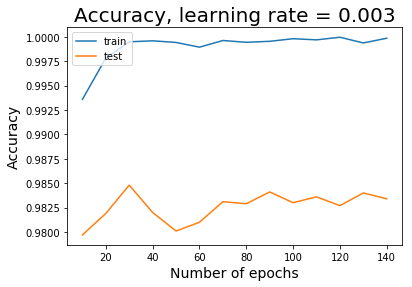

In [19]:
x = epochs_range
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning rate = ' + str(learning_rate), fontsize=20)
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

### Train turget model

In [56]:
epochs = 200
n_chunks = 1000
learning_rate = 0.0005
weight_decay = 0

In [57]:
input_size = 784
output_size = 10
hidden_sizes = [9216, 256, 128]
dropout = 0.0

In [58]:
model = build_model(input_size, output_size, hidden_sizes, dropout)

In [ ]:
fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)

Fitting model with epochs = 200, learning rate = 0.0005
Epoch: 1/200  Loss: 0.5694
Epoch: 1/200  Loss: 0.2505
Epoch: 1/200  Loss: 0.2107
Epoch: 1/200  Loss: 0.1519
Epoch: 1/200  Loss: 0.1721
Epoch: 1/200  Loss: 0.1429
Epoch: 1/200  Loss: 0.1147
Epoch: 1/200  Loss: 0.1192
Epoch: 1/200  Loss: 0.1064
Epoch: 1/200  Loss: 0.0993
Epoch: 2/200  Loss: 0.0736
Epoch: 2/200  Loss: 0.0832
Epoch: 2/200  Loss: 0.0767
Epoch: 2/200  Loss: 0.0796
Epoch: 2/200  Loss: 0.0851
Epoch: 2/200  Loss: 0.0708
Epoch: 2/200  Loss: 0.0692
Epoch: 2/200  Loss: 0.0734
Epoch: 2/200  Loss: 0.0778
Epoch: 2/200  Loss: 0.0618
Epoch: 3/200  Loss: 0.0414
Epoch: 3/200  Loss: 0.0418
Epoch: 3/200  Loss: 0.0507
Epoch: 3/200  Loss: 0.0573
Epoch: 3/200  Loss: 0.0535
Epoch: 3/200  Loss: 0.0636
Epoch: 3/200  Loss: 0.0442
Epoch: 3/200  Loss: 0.0572
Epoch: 3/200  Loss: 0.0509
Epoch: 3/200  Loss: 0.0528
Epoch: 4/200  Loss: 0.0311
Epoch: 4/200  Loss: 0.0290
Epoch: 4/200  Loss: 0.0360
Epoch: 4/200  Loss: 0.0306
Epoch: 4/200  Loss: 0.0454

Epoch: 30/200  Loss: 0.0026
Epoch: 30/200  Loss: 0.0041
Epoch: 30/200  Loss: 0.0061
Epoch: 30/200  Loss: 0.0039
Epoch: 30/200  Loss: 0.0051
Epoch: 30/200  Loss: 0.0024
Epoch: 31/200  Loss: 0.0020
Epoch: 31/200  Loss: 0.0016
Epoch: 31/200  Loss: 0.0022
Epoch: 31/200  Loss: 0.0065
Epoch: 31/200  Loss: 0.0016
Epoch: 31/200  Loss: 0.0011
Epoch: 31/200  Loss: 0.0022
Epoch: 31/200  Loss: 0.0022
Epoch: 31/200  Loss: 0.0036
Epoch: 31/200  Loss: 0.0027
Epoch: 32/200  Loss: 0.0017
Epoch: 32/200  Loss: 0.0019
Epoch: 32/200  Loss: 0.0004
Epoch: 32/200  Loss: 0.0004
Epoch: 32/200  Loss: 0.0018
Epoch: 32/200  Loss: 0.0044
Epoch: 32/200  Loss: 0.0051
Epoch: 32/200  Loss: 0.0046
Epoch: 32/200  Loss: 0.0042
Epoch: 32/200  Loss: 0.0065
Epoch: 33/200  Loss: 0.0057
Epoch: 33/200  Loss: 0.0060
Epoch: 33/200  Loss: 0.0063
Epoch: 33/200  Loss: 0.0079
Epoch: 33/200  Loss: 0.0041
Epoch: 33/200  Loss: 0.0037
Epoch: 33/200  Loss: 0.0022
Epoch: 33/200  Loss: 0.0065
Epoch: 33/200  Loss: 0.0061
Epoch: 33/200  Loss:

In [ ]:
evaluate_model(model, train, train_labels, test, test_labels)

In [ ]:
filepath = '../service/models/model.nnet'

In [ ]:
metainfo = {'input_size': input_size,
            'output_size': output_size,
            'hidden_layers': hidden_sizes,
            'dropout': dropout,
            'state_dict': model.state_dict()}

torch.save(metainfo, filepath)
print("Model saved to {}\n".format(filepath))